In [1]:
# Plots for section 5.4 (hydrogen intersection with other sectors)

## Imports

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, \
    capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, \
    generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO
from utils import generation_links_bus

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse, c_tags
from utils import resistive_heater, gas_boiler, heat_pump,water_tanks_charger, water_tanks_discharger, solar_thermal
from utils import c_el_gen_s, c_el_con_s, c_h2_gen, c_h2_con

# general variables
font1 = {'fontname': 'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/01_general/5.4_hydrogen_whyh2'
PLOT_DIR_add = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/01_general/additional_stuff'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger",
                  "solar thermal"]
markers = ["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

# new indices: cut off Fuel cell and SMR completely and SMR CC for exp
c_h2_gen_stst = ['H2 Electrolysis', 'SMR CC']
c_h2_gen_exp = ['H2 Electrolysis']
c_h2_gen = ['H2 Electrolysis', 'SMR CC']
c_h2_con = ['H2 liquefaction', 'Sabatier', 'Fischer-Tropsch']

In [3]:
# Network imports
stst = pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
exp = pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
# stst and exp dataframes
# spatial
df_stst_ons = pd.read_pickle("../data/processed/df_stst_ons.pkl")
df_stst_off = pd.read_pickle("../data/processed/df_stst_off.pkl")
df_exp_ons = pd.read_pickle("../data/processed/df_exp_ons.pkl")
df_exp_off = pd.read_pickle("../data/processed/df_exp_off.pkl")

# temporal
df_stst_ts = pd.read_pickle("../data/processed/df_stst_ts.pkl")
df_exp_ts = pd.read_pickle("../data/processed/df_exp_ts.pkl")

In [5]:
# Notebook Functions


In [6]:
#assert 0

## Balances

In [7]:
# all buses
stst.buses.carrier.unique()
# Interesting: gas, H2, biogas, solid biomass, solid biomass for industry, gas for industry, H2 liquid, oil,

array(['AC', 'co2', 'co2 stored', 'gas', 'H2', 'battery', 'Li ion',
       'residential rural heat', 'residential rural water tanks',
       'services rural heat', 'services rural water tanks',
       'residential urban decentral heat',
       'residential urban decentral water tanks',
       'services urban decentral heat',
       'services urban decentral water tanks', 'urban central heat',
       'urban central water tanks', 'biogas', 'solid biomass',
       'solid biomass for industry', 'gas for industry', 'H2 liquid',
       'oil', 'process emissions', 'low voltage', 'home battery'],
      dtype=object)

### all heat

In [8]:
stst.buses.carrier.unique()[pd.Index(stst.buses.carrier.unique()).str.contains("heat")].tolist()

['residential rural heat',
 'services rural heat',
 'residential urban decentral heat',
 'services urban decentral heat',
 'urban central heat']

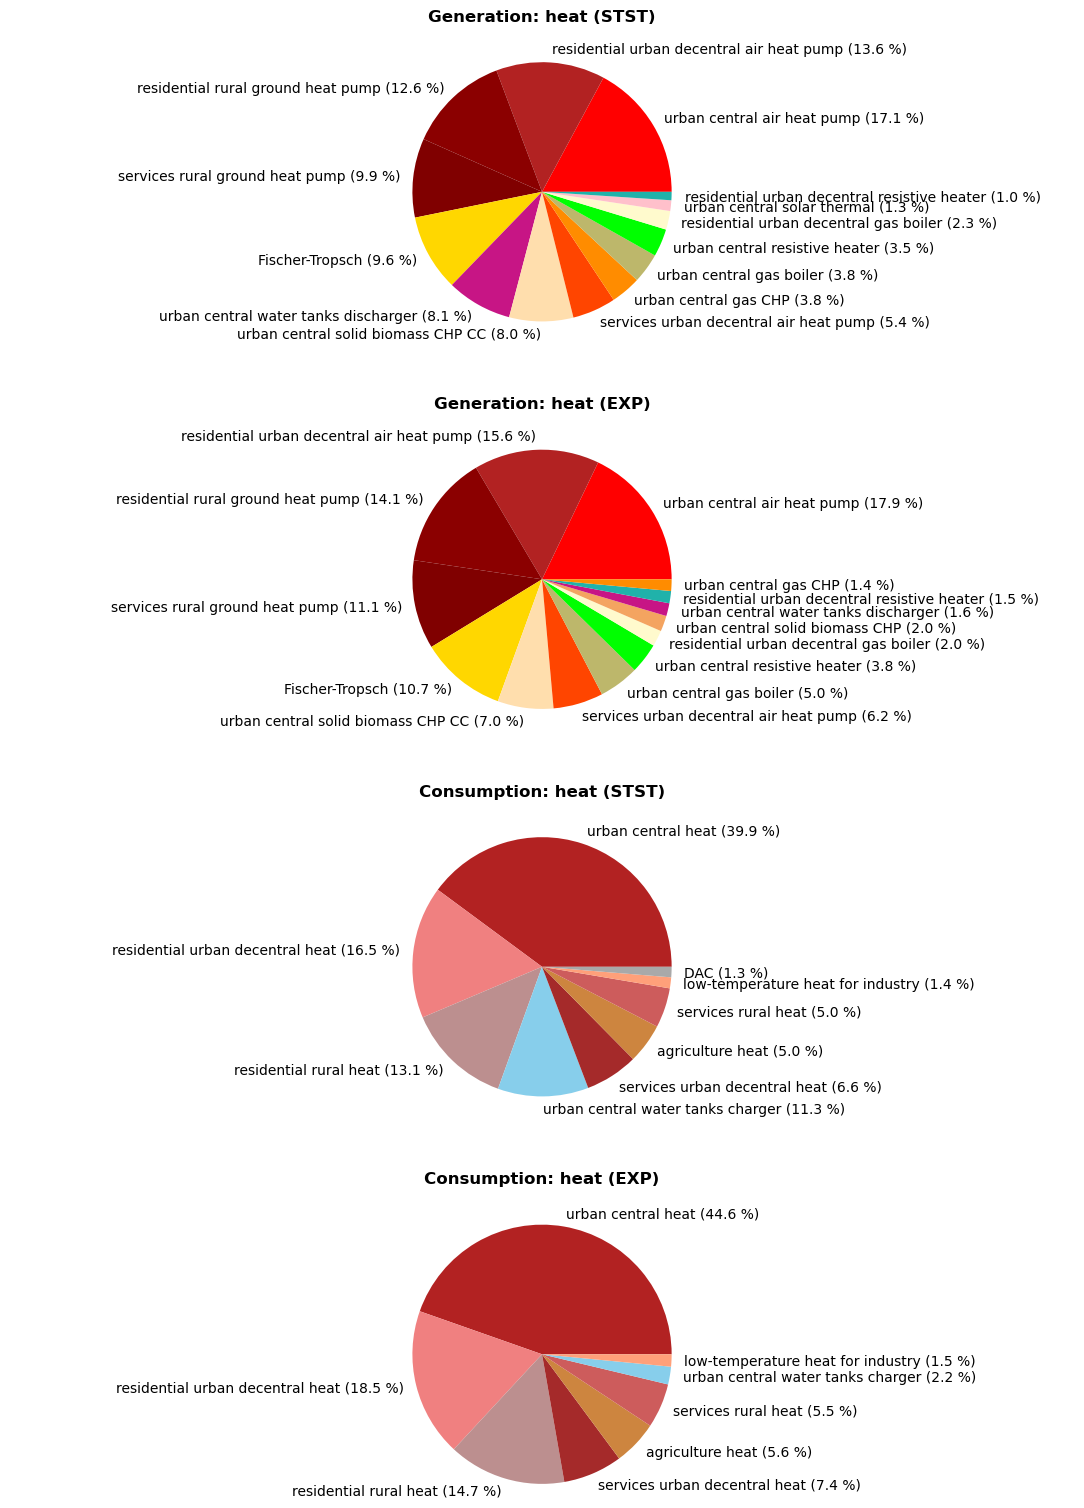

In [9]:
# generation and consumption (all heat)

carriers = ['residential rural heat',
            'services rural heat',
            'residential urban decentral heat',
            'services urban decentral heat',
            'urban central heat']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 4*4))

for n in [stst, exp]:

    nb = nodal_balance(n, carrier=carriers, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0]
        ax_con=axs[2]
        title_gen=f"Generation: heat (STST)"
        title_con=f"Consumption: heat (STST)"

    elif n==exp:
        ax_gen=axs[1]
        ax_con=axs[3]
        title_gen=f"Generation: heat (EXP)"
        title_con=f"Consumption: heat (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=4)
#plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}/heat_gen_con.png")

In [10]:
# Overall heat generation

model = "EXP"

if model == "STST":
    n = stst

elif model == "EXP":
    n = exp

carrier = ['residential rural heat',
            'services rural heat',
            'residential urban decentral heat',
            'services urban decentral heat',
            'urban central heat']

nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MWh to GWh
nb = nb.unstack(level=[1]) / 1000
# condense condense_groups
nb = get_condense_sum(nb, c1_groups, c1_groups_name)
# rename unhandy column names
nb.rename(columns=carrier_renaming, inplace=True)

nb[nb > 0].sum().sum() / 1e3

# STST: 3818 TWh
# EXP: 3407 TWh

3407.0324946381565

### urban central heat

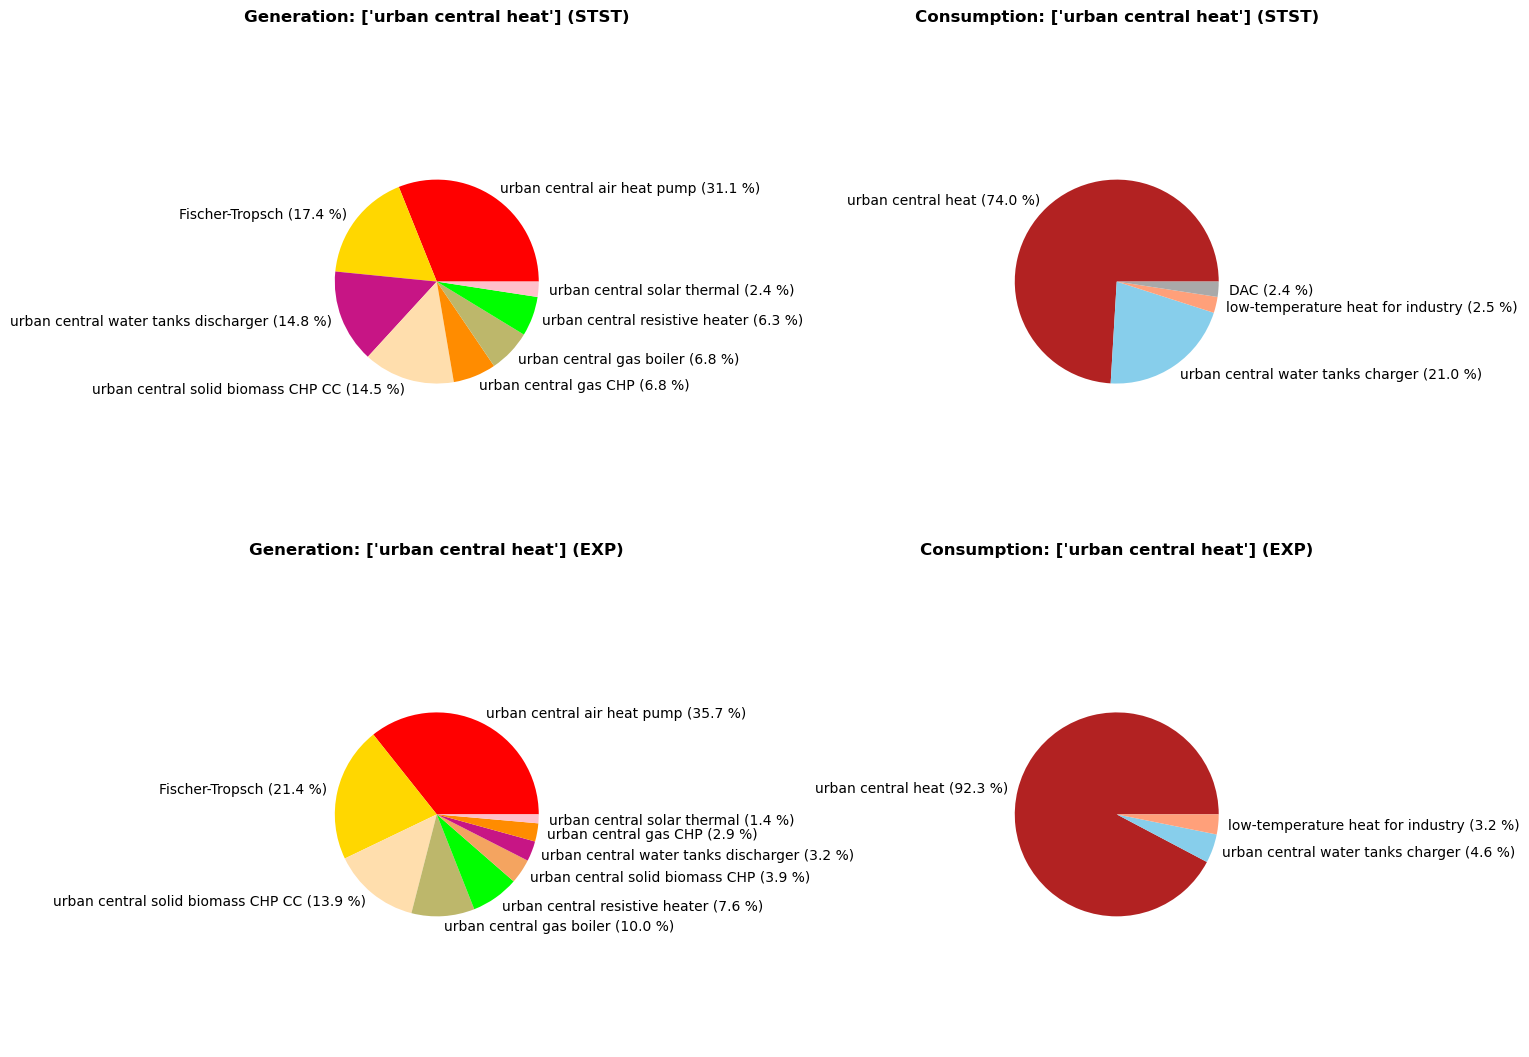

In [11]:
# generation and consumption (urban central heat)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["urban central heat"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
#plt.close()
plt.show()

# Fischer Tropsch nebenprdukt Heat

### oil

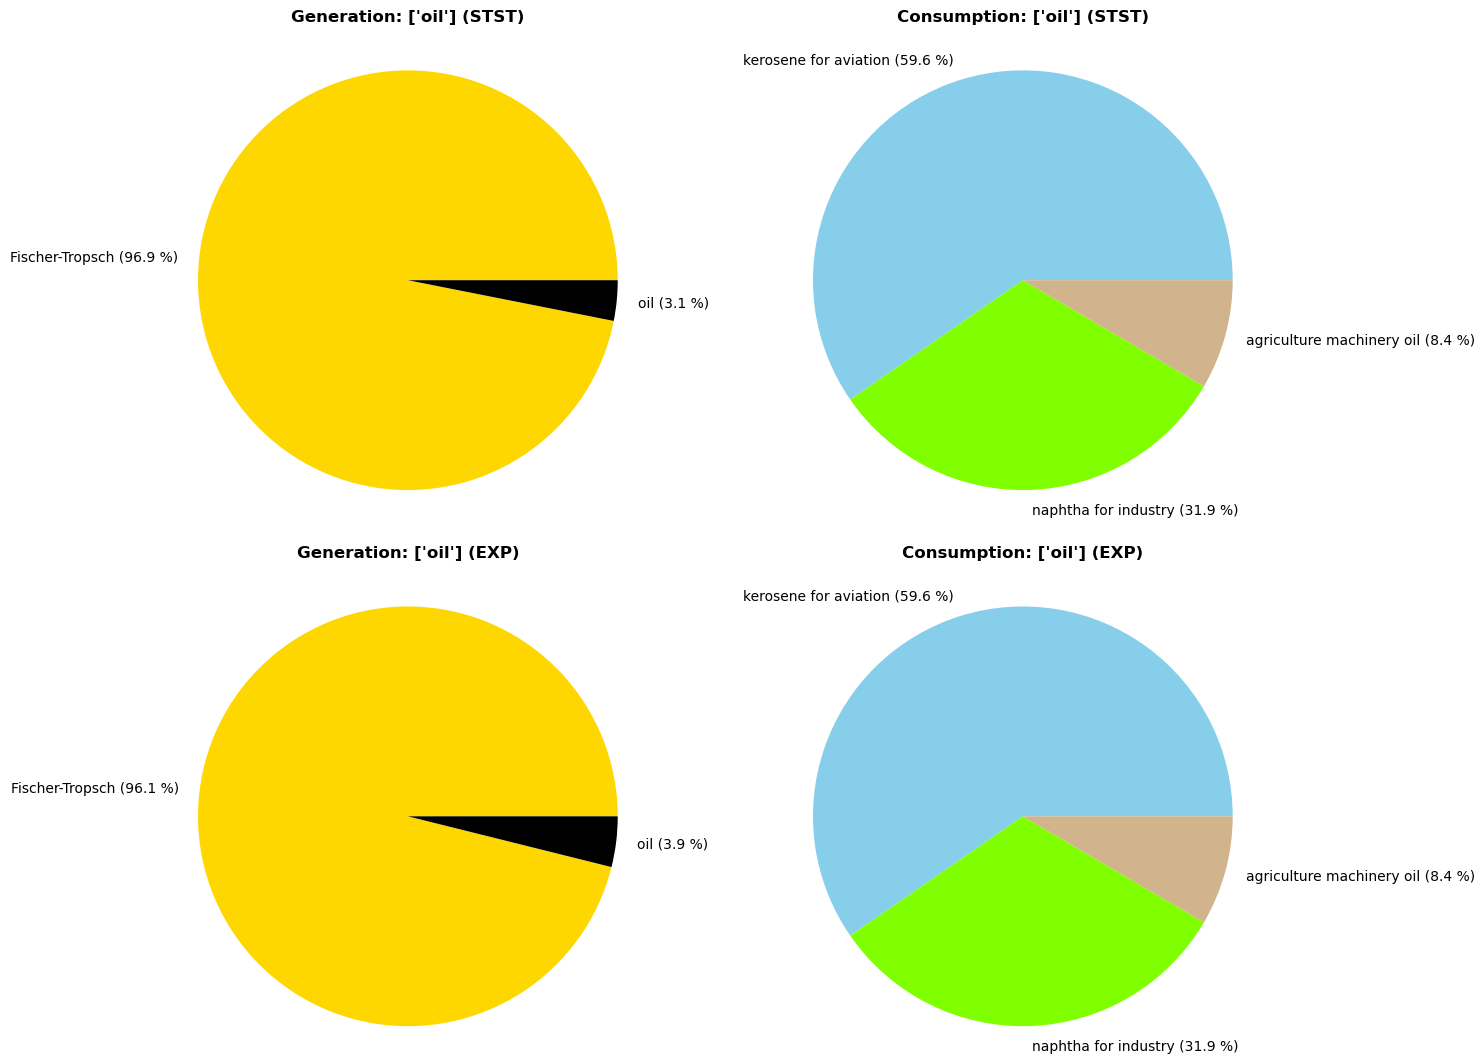

In [12]:
# generation and consumption (oil)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["oil"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, startangle=0, colors=c, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg,  startangle=0, colors=c, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
#plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}/oil_gen_con.png")

### gas

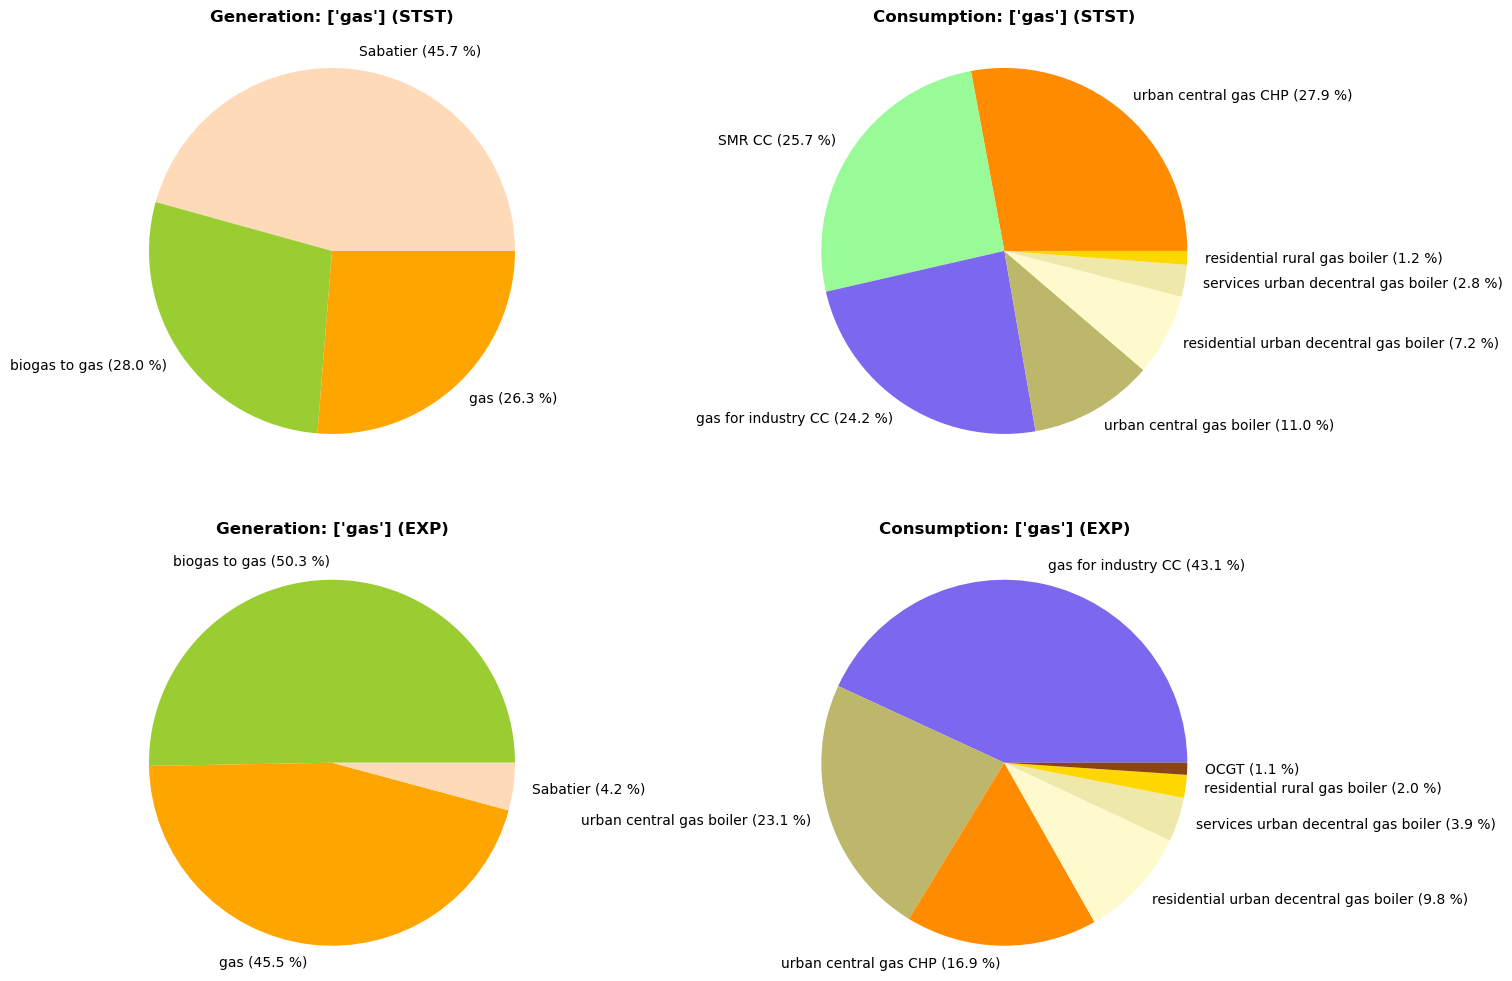

In [13]:
# generation and consumption (gas)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["gas"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, startangle=0, colors=c, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg,  startangle=0, colors=c, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
#plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}/gas_gen_con.png")

In [14]:
n = exp
carrier = ["gas"]
nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MW to GW
nb = nb.unstack(level=[1]) / 1000

nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
# exclude all shares smaller than 1 %
nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
# exclude all shares smaller than 1 %
nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

### testing carrier

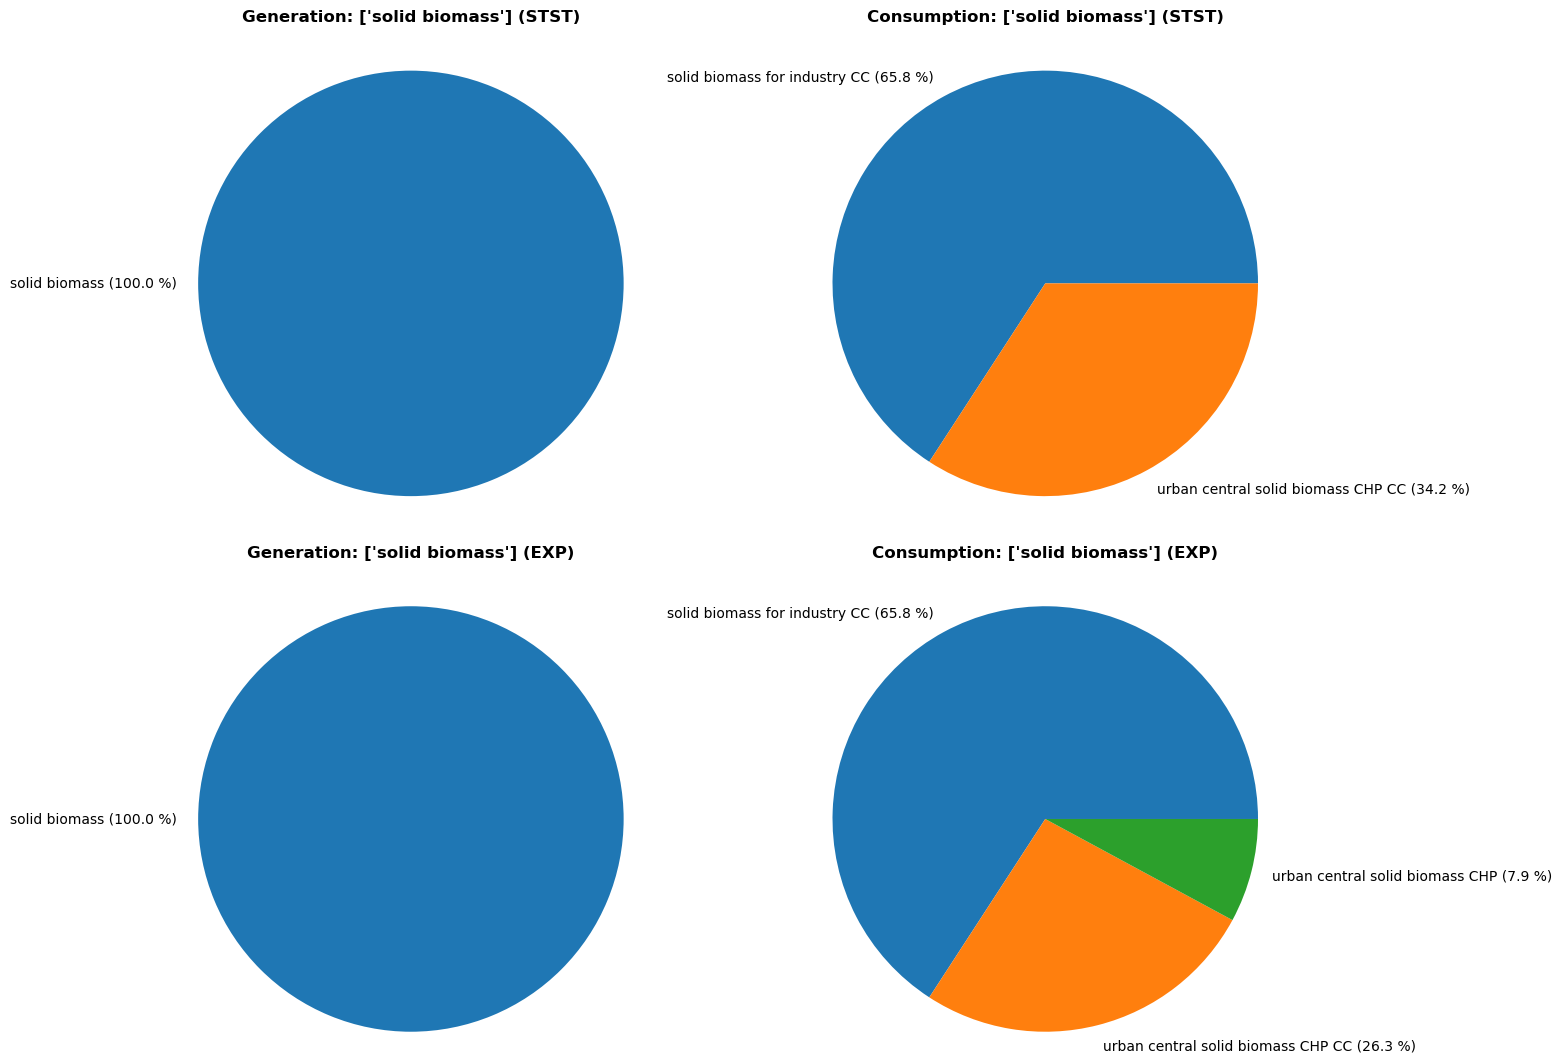

In [15]:
# generation and consumption
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["solid biomass"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    #c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    #c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg,  startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
#plt.close()
plt.show()

### testing buses

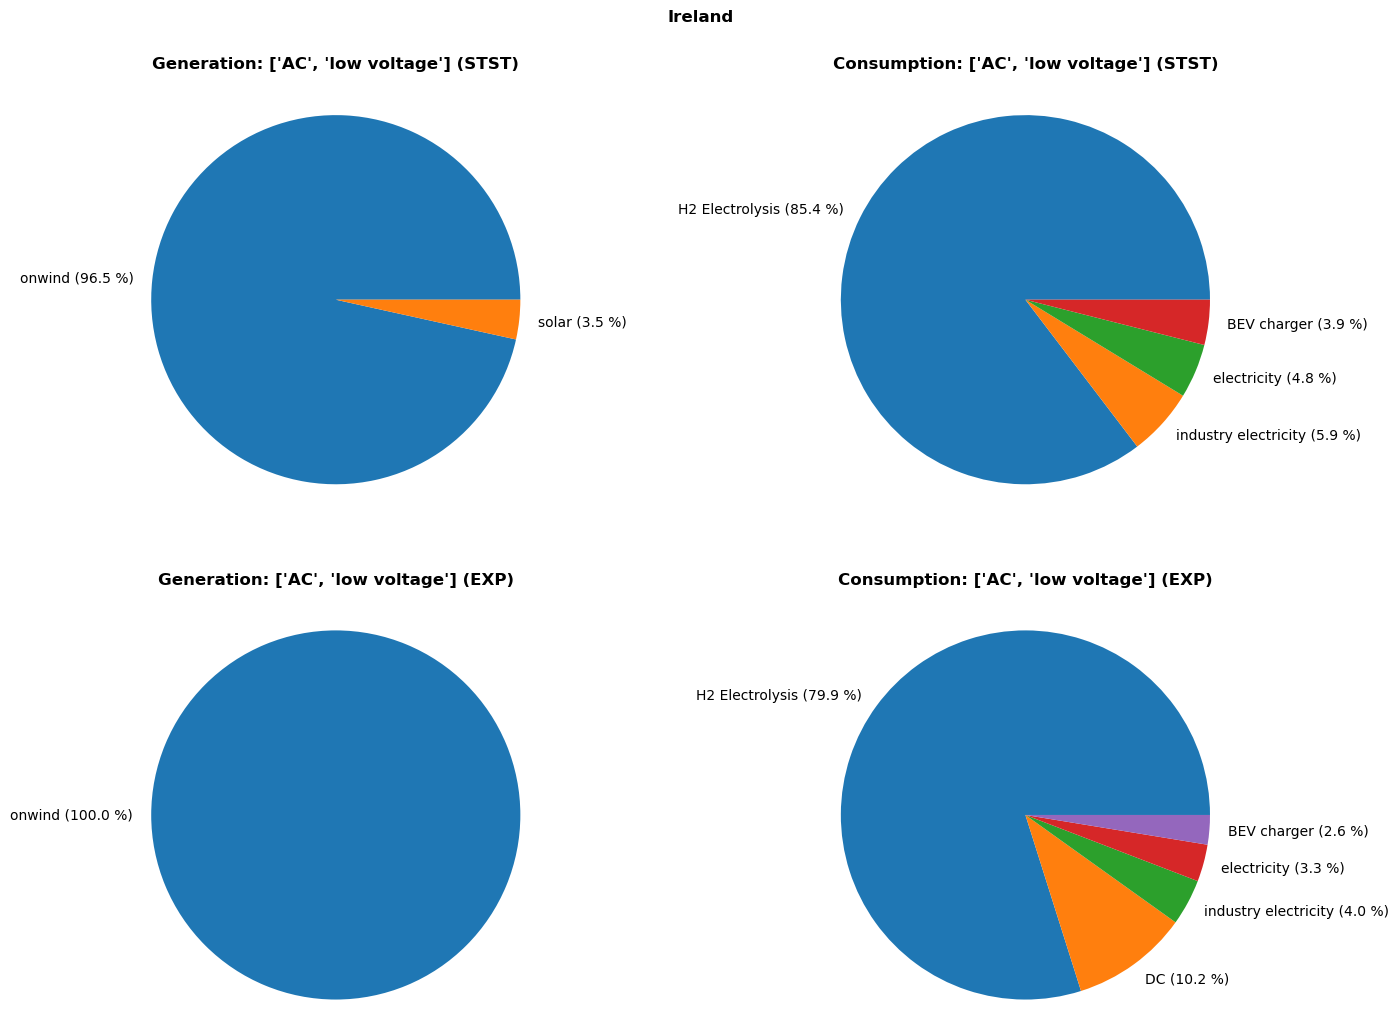

In [16]:
# norway indices
i_buses = df_stst_ons.index[df_stst_ons.index.str.contains("IE")]
country = "Ireland"

# generation and consumption
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["AC", "low voltage"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component'], energy=True)

    nb = pd.DataFrame(nb)
    nb = nb.unstack(level=[1])
    nb.columns = nb.columns.droplevel(0)
    nb = nb[i_buses].sum(axis=1)
    nb = nb.unstack(level=[1])

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    #c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    #c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg,  startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
fig.suptitle(country, fontweight="bold")
#plt.close()
plt.show()
#fig.savefig(f"{PLOT_DIR_add}/el_gen_con_{country}.png")

## Sabatier

In [17]:
# gas production
# Sabatier: 563 TWh (STST), 29 TWh (EXP)
c = "Sabatier"

In [18]:
df_stst_ons[f"{c}_gen_gas"]

name
AL0 0   NaN
AT0 0   NaN
AT0 1   NaN
AT0 2   NaN
BA0 0   NaN
         ..
SE3 5   NaN
SE3 6   NaN
SE3 7   NaN
SI0 0   NaN
SK0 0   NaN
Name: Sabatier_gen_gas, Length: 181, dtype: float64

In [19]:
n = stst
n.links[n.links.carrier == "Sabatier"]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,n_mod
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 Sabatier,AL0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 0 Sabatier,AT0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 1 Sabatier,AT0 1 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 2 Sabatier,AT0 2 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
BA0 0 Sabatier,BA0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 Sabatier,SE3 5 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
SE3 6 Sabatier,SE3 6 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
SE3 7 Sabatier,SE3 7 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0


## Fischer-Tropsch


In [20]:
c = "Fischer-Tropsch"
n = stst
carrier = ["oil"]
carrier = ['residential rural heat',
            'services rural heat',
            'residential urban decentral heat',
            'services urban decentral heat',
            'urban central heat']

nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MW to GW
nb = nb.unstack(level=[1]) / 1000

nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
# exclude all shares smaller than 1 %
nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
# exclude all shares smaller than 1 %
nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

In [21]:
nb_pos / 1e3

# Oil production: 995 TWh (STST), 986 TWh (EXP)
# total heat production: 355 TWh (STST), 352 TWh (EXP)

carrier
urban central air heat pump                     636.187172
residential urban decentral air heat pump       504.181469
residential rural ground heat pump              468.286691
services rural ground heat pump                 365.918174
Fischer-Tropsch                                 355.249533
urban central water tanks discharger            302.451510
urban central solid biomass CHP CC              296.570120
services urban decentral air heat pump          201.162255
urban central gas CHP                           139.465576
urban central gas boiler                        139.360398
urban central resistive heater                  128.680866
residential urban decentral gas boiler           86.419404
urban central solar thermal                      49.520527
residential urban decentral resistive heater     38.601290
dtype: float64

## Loads

In [22]:
c_loads = n.loads.carrier.unique()
df_loads = pd.DataFrame(index = c_loads, columns=["overall_load"])
df_loads.index[df_loads.index.str.contains("heat")]

Index(['residential rural heat', 'services rural heat',
       'residential urban decentral heat', 'services urban decentral heat',
       'urban central heat', 'low-temperature heat for industry',
       'agriculture heat'],
      dtype='object')

In [23]:
for c_l in c_loads:
    index = n.loads[n.loads.carrier == c_l].index
    df_loads.loc[c_l , "overall_load"] = n.loads_t.p.loc[: , index].sum().sum() / 1e6 * 3 # TWh

In [24]:
df_loads.sort_values(by="overall_load", ascending=False)

,overall_load
electricity,1720.767554
industry electricity,1702.52
urban central heat,1517.120729
land transport EV,779.898679
solid biomass for industry,702.4
residential urban decentral heat,628.402898
kerosene for aviation,612.245731
H2 for shipping,502.844346
residential rural heat,498.690501
naphtha for industry,327.78


In [25]:
stst.loads_t.p.loc[: , stst.loads.carrier.isin(["electricity"])]

Load,AL0 0,AT0 0,AT0 1,AT0 2,BA0 0,BE0 0,BE0 1,BE0 2,BE0 3,BE0 4,...,SE3 0,SE3 1,SE3 2,SE3 3,SE3 4,SE3 5,SE3 6,SE3 7,SI0 0,SK0 0
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,300.421829,1174.814546,330.404508,1058.962951,793.231297,1012.407307,581.290313,598.940208,279.845854,491.197844,...,2583.607100,217.839264,461.530444,1334.081028,134.251651,278.378708,881.956399,167.852332,765.887709,1001.537022
2013-01-01 03:00:00,193.027966,931.386992,298.419231,909.306915,614.605319,852.335135,467.544840,451.984775,210.282534,378.730608,...,2138.437729,194.089691,410.371118,1118.102351,119.140355,252.579608,654.553723,152.194528,660.314072,771.643294
2013-01-01 06:00:00,178.781684,1063.035323,334.066769,1025.438893,705.467039,840.685574,460.163741,443.420775,206.249813,371.958316,...,2293.921340,207.333017,438.404231,1198.744849,127.276537,269.529565,706.590942,162.448627,666.463045,789.588444
2013-01-01 09:00:00,238.642397,1309.232418,386.837886,1215.968991,879.023143,1000.683803,563.934722,566.734724,264.388194,468.745523,...,2642.975019,231.308337,489.514812,1373.726317,142.217473,298.347557,855.265944,179.902882,743.246281,980.218485
2013-01-01 12:00:00,257.383976,1291.204314,380.115055,1196.534077,907.066419,1016.093613,575.653695,582.708670,271.967815,480.783623,...,2864.817210,247.559411,524.080177,1486.002995,152.298643,318.288957,944.147584,191.976082,727.953648,1014.961679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,317.809501,1627.175678,441.963625,1429.985744,1126.542004,1305.165083,751.684394,781.143575,367.047345,638.514690,...,2908.675917,241.468012,525.099412,1427.351382,152.389970,327.396591,998.560152,185.304870,1004.231170,1235.536327
2013-12-31 12:00:00,333.412768,1510.137642,411.843072,1330.043452,1167.187332,1282.178553,739.903460,770.675789,362.082115,629.477915,...,3048.667026,251.824517,546.566176,1501.267804,158.665586,339.306515,1054.696710,193.024145,961.958628,1237.471797
2013-12-31 15:00:00,370.846214,1638.488337,446.183696,1441.876495,1275.842701,1345.493439,777.361330,810.988101,381.040552,662.124353,...,3169.243767,262.065203,569.343736,1557.904972,165.245004,354.063680,1094.003643,200.942683,1051.385513,1251.801357


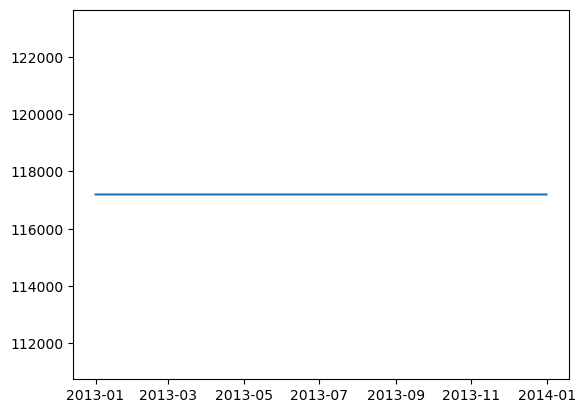

In [26]:
# Fischer Tropsch loads
plt.plot(stst.loads_t.p.loc[: , stst.loads.carrier.isin(["kerosene for aviation", "naphtha for industry", "agriculture machinery oil"])].sum(axis=1))

## Additional stuff

In [27]:
# Active power at bus0 (positive if branch is withdrawing power from bus0).

In [28]:
stst.links[stst.links.carrier == "Sabatier"]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,n_mod
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 Sabatier,AL0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 0 Sabatier,AT0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 1 Sabatier,AT0 1 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 2 Sabatier,AT0 2 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
BA0 0 Sabatier,BA0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 Sabatier,SE3 5 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
SE3 6 Sabatier,SE3 6 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
SE3 7 Sabatier,SE3 7 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0


In [29]:
stst.links_t.p2.loc[: , stst.links.carrier == "Sabatier"]

Link,AL0 0 Sabatier,AT0 0 Sabatier,AT0 1 Sabatier,AT0 2 Sabatier,BA0 0 Sabatier,BE0 0 Sabatier,BE0 1 Sabatier,BE0 2 Sabatier,BE0 3 Sabatier,BE0 4 Sabatier,...,SE3 0 Sabatier,SE3 1 Sabatier,SE3 2 Sabatier,SE3 3 Sabatier,SE3 4 Sabatier,SE3 5 Sabatier,SE3 6 Sabatier,SE3 7 Sabatier,SI0 0 Sabatier,SK0 0 Sabatier
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000673,0.000655,0.000575,0.000637,0.000701,13.795685,0.000440,0.000317,0.000421,0.000298,...,13.562243,0.049260,0.023064,145.957473,0.098177,0.010292,0.002453,0.183010,0.000500,0.000710
2013-01-01 03:00:00,0.000665,0.000652,0.000574,0.000641,0.000705,4.436971,0.000368,0.000308,0.000402,0.000300,...,13.563521,0.046565,0.022874,145.957623,0.096392,0.010667,0.002471,0.179376,0.000495,0.000714
2013-01-01 06:00:00,0.000658,0.000651,0.000576,0.000644,0.000709,4.067712,0.000364,0.000302,0.000391,0.000298,...,4.255009,0.045184,0.021904,145.957695,0.093729,0.011229,0.002410,0.173306,0.000494,0.000722
2013-01-01 09:00:00,0.000657,0.000646,0.000572,0.000640,0.000705,4.158643,0.000362,0.000300,0.000389,0.000298,...,2.926192,0.045876,0.022291,145.957088,0.089677,0.011842,0.002408,0.161502,0.000494,0.000719
2013-01-01 12:00:00,0.000655,0.000651,0.000582,0.000651,0.000703,4.151261,0.000361,0.000299,0.000350,0.000300,...,0.003593,0.002037,0.001799,0.003189,0.002109,0.001777,0.002809,0.001394,0.000492,0.000719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000645,0.000543,0.000413,0.000546,0.000743,68.511665,0.000435,0.000312,0.000385,0.000323,...,13.563646,0.070342,0.031385,145.957693,0.096191,0.012042,0.002520,0.195113,0.000412,0.000718
2013-12-31 12:00:00,0.000651,0.000547,0.000415,0.000549,0.000754,63.814193,0.000438,0.000315,0.000388,0.000325,...,13.563507,0.071933,0.031114,145.957509,0.096545,0.012186,0.002457,0.195110,0.000413,0.000724
2013-12-31 15:00:00,0.000656,0.000547,0.000416,0.000550,0.000753,45.986745,0.000441,0.000315,0.000386,0.000325,...,13.563342,0.072970,0.031436,145.957532,0.096505,0.012522,0.002403,0.192970,0.000413,0.000723


In [30]:
stst.links[stst.links.carrier == "SMR CC"]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,n_mod
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 SMR CC,EU gas,AL0 0 H2,SMR CC,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 0 SMR CC,EU gas,AT0 0 H2,SMR CC,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 1 SMR CC,EU gas,AT0 1 H2,SMR CC,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
AT0 2 SMR CC,EU gas,AT0 2 H2,SMR CC,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
BA0 0 SMR CC,EU gas,BA0 0 H2,SMR CC,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 SMR CC,EU gas,SE3 5 H2,SMR CC,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
SE3 6 SMR CC,EU gas,SE3 6 H2,SMR CC,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0
SE3 7 SMR CC,EU gas,SE3 7 H2,SMR CC,,0.0,0.0,,NaN,NaN,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0


In [31]:
stst.links_t.p2.loc[: , stst.links.carrier == "SMR CC"]

Link,AL0 0 SMR CC,AT0 0 SMR CC,AT0 1 SMR CC,AT0 2 SMR CC,BA0 0 SMR CC,BE0 0 SMR CC,BE0 1 SMR CC,BE0 2 SMR CC,BE0 3 SMR CC,BE0 4 SMR CC,...,SE3 0 SMR CC,SE3 1 SMR CC,SE3 2 SMR CC,SE3 3 SMR CC,SE3 4 SMR CC,SE3 5 SMR CC,SE3 6 SMR CC,SE3 7 SMR CC,SI0 0 SMR CC,SK0 0 SMR CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-0.002051,-32.427057,-1.086940,-12.700537,-3.310234,-0.000159,-0.000563,-69.105904,-0.000839,-57.901090,...,-0.000124,-0.000137,-0.000137,-0.000098,-0.000154,-0.000140,-0.000210,-0.000136,-5.981609,-24.577634
2013-01-01 03:00:00,-0.002062,-32.312327,-1.179890,-12.558631,-3.310510,-0.000157,-0.001000,-70.334503,-0.000887,-57.914663,...,-0.000123,-0.000138,-0.000137,-0.000098,-0.000154,-0.000141,-0.000207,-0.000136,-5.981610,-24.223425
2013-01-01 06:00:00,-0.002081,-32.177673,-1.242141,-12.354334,-3.310818,-0.000156,-0.000973,-70.805015,-0.000891,-57.965739,...,-0.000131,-0.000137,-0.000137,-0.000097,-0.000154,-0.000140,-0.000206,-0.000136,-5.981611,-23.697571
2013-01-01 09:00:00,-0.002061,-31.775093,-1.214496,-11.413319,-3.310031,-0.000153,-0.000953,-60.647747,-0.000872,-57.967144,...,-0.000129,-0.000135,-0.000134,-0.000103,-0.000150,-0.000138,-0.000204,-0.000134,-5.981612,-21.944492
2013-01-01 12:00:00,-0.002060,-31.999116,-1.478320,-12.393147,-3.309712,-0.000152,-0.000861,-54.928864,-0.001991,-57.967385,...,-0.000184,-0.000192,-0.000187,-0.000186,-0.000217,-0.000189,-0.000202,-0.000194,-5.981607,-23.328356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,-0.002096,-33.032445,-0.596687,-13.304617,-3.311451,-0.000146,-0.000563,-22.160509,-0.000804,-57.928960,...,-0.000123,-0.000137,-0.000139,-0.000100,-0.000152,-0.000145,-0.000219,-0.000138,-5.981579,-25.533791
2013-12-31 12:00:00,-0.002083,-33.007979,-0.610496,-13.301741,-3.311758,-0.000146,-0.000552,-61.153871,-0.000810,-57.930248,...,-0.000123,-0.000137,-0.000139,-0.000100,-0.000152,-0.000145,-0.000219,-0.000139,-5.981580,-25.541928
2013-12-31 15:00:00,-0.002077,-32.955804,-1.014287,-13.262388,-3.311898,-0.000147,-0.000563,-71.055489,-0.000802,-57.929696,...,-0.000124,-0.000138,-0.000140,-0.000101,-0.000154,-0.000147,-0.000222,-0.000141,-5.981584,-25.479015


In [32]:
stst.links_t.p3.loc[: , stst.links.carrier == "SMR CC"]

Link,AL0 0 SMR CC,AT0 0 SMR CC,AT0 1 SMR CC,AT0 2 SMR CC,BA0 0 SMR CC,BE0 0 SMR CC,BE0 1 SMR CC,BE0 2 SMR CC,BE0 3 SMR CC,BE0 4 SMR CC,...,SE3 0 SMR CC,SE3 1 SMR CC,SE3 2 SMR CC,SE3 3 SMR CC,SE3 4 SMR CC,SE3 5 SMR CC,SE3 6 SMR CC,SE3 7 SMR CC,SI0 0 SMR CC,SK0 0 SMR CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-0.018457,-291.843511,-9.782457,-114.304831,-29.792108,-0.001429,-0.005071,-621.953138,-0.007551,-521.109811,...,-0.001114,-0.001235,-0.001237,-0.000884,-0.001384,-0.001261,-0.001886,-0.001224,-53.834481,-221.198702
2013-01-01 03:00:00,-0.018557,-290.810946,-10.619010,-113.027681,-29.794590,-0.001417,-0.009003,-633.010527,-0.007980,-521.231970,...,-0.001109,-0.001238,-0.001229,-0.000882,-0.001389,-0.001265,-0.001859,-0.001227,-53.834488,-218.010828
2013-01-01 06:00:00,-0.018726,-289.599053,-11.179273,-111.189009,-29.797366,-0.001401,-0.008755,-637.245139,-0.008019,-521.691650,...,-0.001180,-0.001236,-0.001231,-0.000876,-0.001387,-0.001262,-0.001851,-0.001225,-53.834502,-213.278143
2013-01-01 09:00:00,-0.018553,-285.975834,-10.930462,-102.719867,-29.790281,-0.001380,-0.008574,-545.829719,-0.007845,-521.704296,...,-0.001163,-0.001219,-0.001207,-0.000929,-0.001354,-0.001238,-0.001838,-0.001204,-53.834504,-197.500432
2013-01-01 12:00:00,-0.018541,-287.992042,-13.304876,-111.538319,-29.787405,-0.001366,-0.007747,-494.359780,-0.017916,-521.706461,...,-0.001658,-0.001730,-0.001687,-0.001676,-0.001953,-0.001703,-0.001818,-0.001745,-53.834463,-209.955207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,-0.018865,-297.292005,-5.370181,-119.741554,-29.803060,-0.001318,-0.005068,-199.444577,-0.007237,-521.360644,...,-0.001105,-0.001234,-0.001254,-0.000901,-0.001370,-0.001307,-0.001970,-0.001246,-53.834215,-229.804119
2013-12-31 12:00:00,-0.018745,-297.071812,-5.494468,-119.715665,-29.805823,-0.001312,-0.004971,-550.384842,-0.007289,-521.372230,...,-0.001103,-0.001231,-0.001249,-0.000902,-0.001371,-0.001306,-0.001971,-0.001252,-53.834223,-229.877354
2013-12-31 15:00:00,-0.018696,-296.602233,-9.128587,-119.361493,-29.807085,-0.001323,-0.005069,-639.499401,-0.007215,-521.367260,...,-0.001115,-0.001246,-0.001259,-0.000908,-0.001386,-0.001320,-0.002001,-0.001268,-53.834255,-229.311139


In [33]:
stst.buses_t.marginal_price.loc[: , stst.buses.carrier == "gas"]

Bus,EU gas
snapshot,
2013-01-01 00:00:00,20.109148
2013-01-01 03:00:00,20.109148
2013-01-01 06:00:00,20.109148
2013-01-01 09:00:00,20.109148
2013-01-01 12:00:00,20.109148
...,...
2013-12-31 09:00:00,20.109148
2013-12-31 12:00:00,20.109148
2013-12-31 15:00:00,20.109148


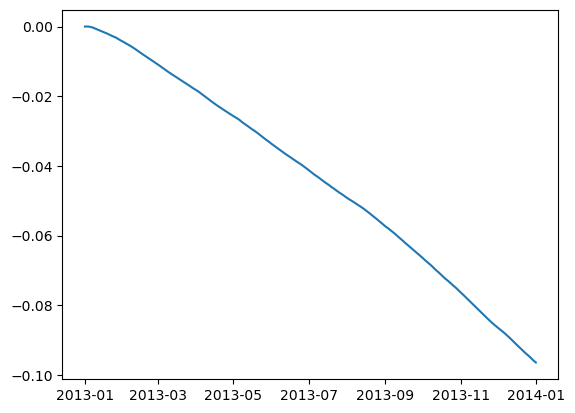

In [34]:
plt.plot(stst.buses_t.p.loc[:, stst.buses.carrier == "co2 stored"].cumsum())

In [35]:
stst.buses.carrier.unique()

array(['AC', 'co2', 'co2 stored', 'gas', 'H2', 'battery', 'Li ion',
       'residential rural heat', 'residential rural water tanks',
       'services rural heat', 'services rural water tanks',
       'residential urban decentral heat',
       'residential urban decentral water tanks',
       'services urban decentral heat',
       'services urban decentral water tanks', 'urban central heat',
       'urban central water tanks', 'biogas', 'solid biomass',
       'solid biomass for industry', 'gas for industry', 'H2 liquid',
       'oil', 'process emissions', 'low voltage', 'home battery'],
      dtype=object)

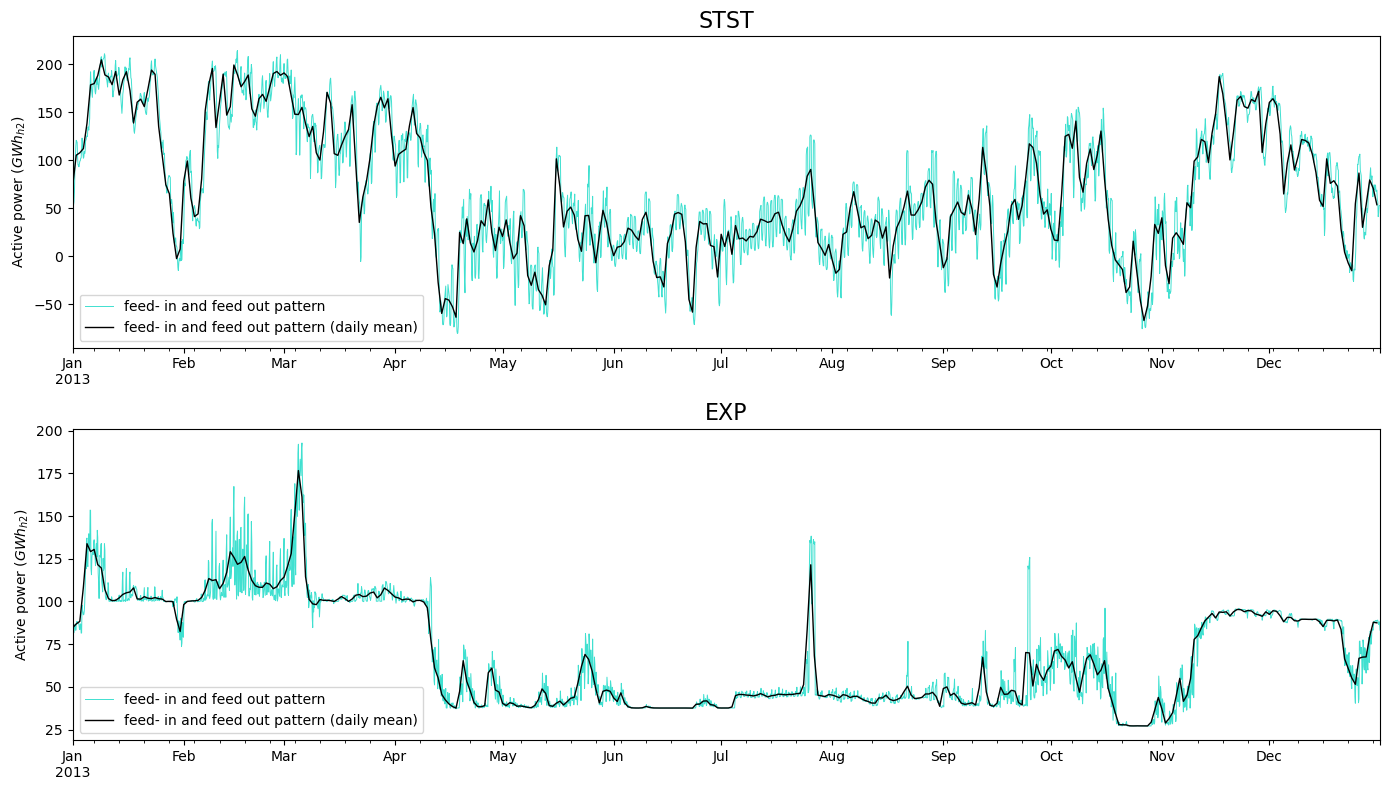

In [36]:
# p: active power at bus (positive if net production) (MW)

# GWh
n = stst
# indices are the same
i_co2_stored_stores = n.stores[n.stores.carrier == "co2 stored"].index

fig, axs = plt.subplots(nrows=2, figsize=(14, 8))

for n, ax in zip([stst, exp], axs):
    (-(n.stores_t.p[i_co2_stored_stores].sum(axis=1) / 1e3 * 3).resample("3h").sum()).plot(ax=ax,
                                                                                lw=0.7,
                                                                                color='turquoise',
                                                                                label="feed- in and feed out pattern")
    (-(n.stores_t.p[i_co2_stored_stores].sum(axis=1) / 1e3 * 3).resample("D").mean()).plot(ax=ax,
                                                                                lw=1,
                                                                                color='black',
                                                                               label="feed- in and feed out pattern (daily mean)")
    ax.set_ylabel("Active power ($GWh_{h2}$)")
    ax.set_xlabel("")
    ax.set_title("STST" if n == stst else "EXP", fontsize=16, **font1)
    ax.legend(loc="lower left")

fig.tight_layout()

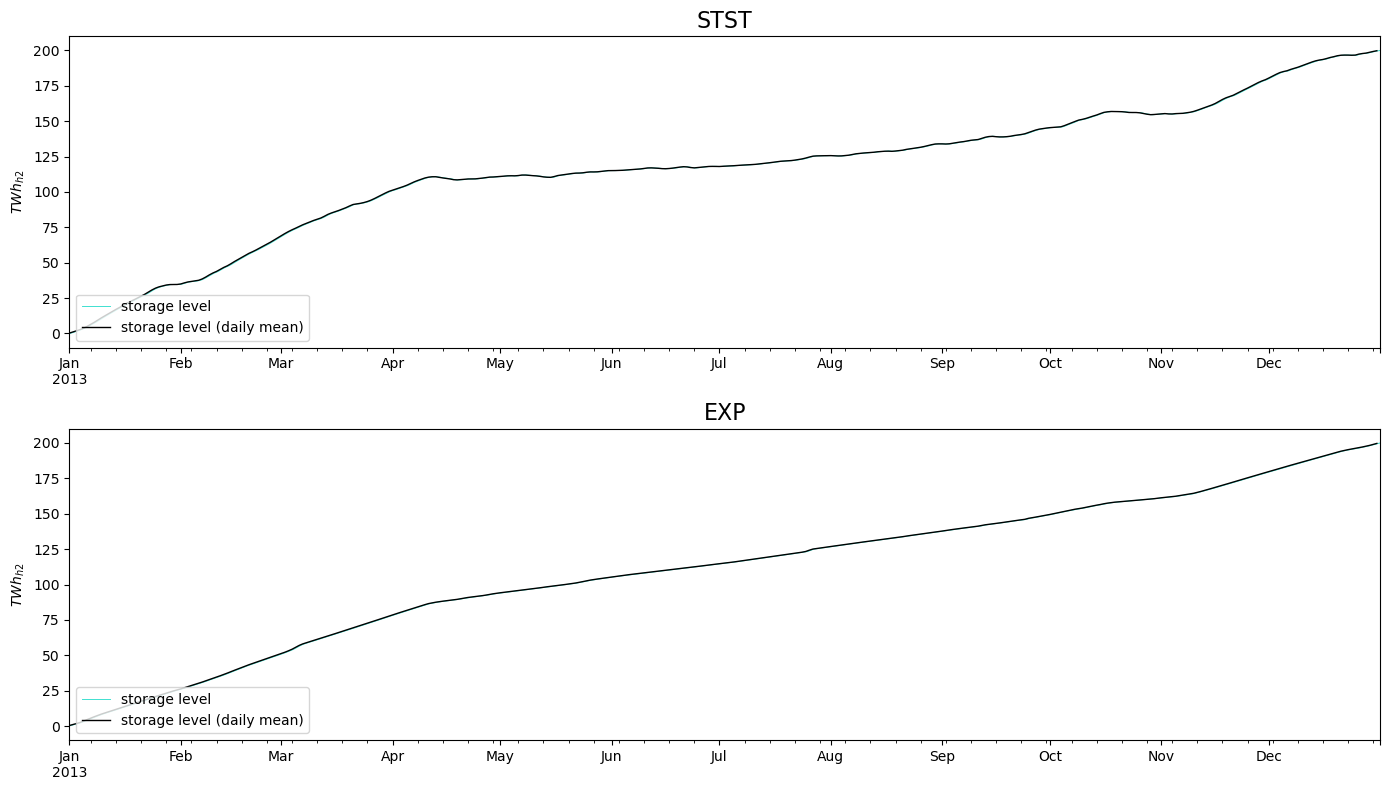

In [37]:
fig, axs = plt.subplots(nrows=2, figsize=(14, 8))

for n, ax in zip([stst, exp], axs):
    (n.stores_t.e[i_co2_stored_stores].sum(axis=1) / 1e6).resample("3h").sum().plot(ax=ax,
                                                                                lw=0.7,
                                                                                color='turquoise',
                                                                                label="storage level")
    (n.stores_t.e[i_co2_stored_stores].sum(axis=1) / 1e6).resample("D").mean().plot(ax=ax,
                                                                                lw=1,
                                                                                color='black',
                                                                               label="storage level (daily mean)")
    ax.set_ylabel("$TWh_{h2}$")
    ax.set_xlabel("")
    ax.set_title("STST" if n == stst else "EXP", fontsize=16, **font1)
    ax.legend(loc="lower left")

fig.tight_layout()

In [38]:
-(n.stores_t.p[i_co2_stored_stores].sum(axis=1) / 1e6 * 3).sum() # restriction of 200 MtCO2 pro Jahr

199.9999999975373